# Реализация и тестирование предсказаний класса прогноза доходов

#### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from catboost import Pool
import shap as shap


import matplotlib as matplotlib
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

Matplotlib: 3.3.4
Seaborn: 0.11.1


In [2]:
SEED = 42
FIGSIZE = (12,5)
FONTSIZE = 14
YEARS_PREDICT = 3

#### Загрузка данных

In [3]:
PATH = '../data/'

try:
    X = pd.read_csv(PATH+'features.csv', index_col=0)
    y = pd.read_csv(PATH+'target.csv', index_col=0)
    inflation = pd.read_csv(PATH+'inflation.csv', index_col=0)
    print('All of the data has been loaded successfully!')
except Exception as err:
    print(repr(err))
print()

All of the data has been loaded successfully!



In [4]:
y.loc[y.iloc[-1].name + 1,:] = np.nan
y.loc[y.iloc[-1].name + 1,:] = np.nan

Добавим внешние данные по инфляции

In [5]:
inflation

,Прогноз (%),Факт (%)
Год,,
2011,8.00,6.10
2012,6.10,6.60
2013,6.40,6.50
2014,4.75,11.40
2015,8.00,12.90
2016,5.75,5.40
2017,2.50,2.50
2018,4.20,4.30
2019,4.95,3.00


In [6]:
X = pd.concat([X, inflation['Прогноз (%)']], axis=1)

In [7]:
TARGETS = ['Налог на доходы физических лиц', 'Налог на прибыль организаций']

### Класс с реализацией ансамбля моделей

In [8]:
class BudgetModel():
    def __init__(self, X, y, years_to_predict=2, random_seed=42):
        self.SEED = random_seed
        self.years_to_predict = years_to_predict
        self.X_train, self.X_test = 0, 0
        self.y_train, self.y_test = 0, 0
        self.feature_importance = []
        
        self.X = X
        self.y = y
        
        self.X = self.X.dropna(axis=1)
        self.X_train, self.X_test = self.X[:-self.years_to_predict], self.X[-self.years_to_predict:]
        self.y_train, self.y_test = self.y[:-self.years_to_predict], self.y[-self.years_to_predict:]

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)


    def predict(self):
        catboost_params = {
            'depth': 1,
            'iterations': 10000,
            'learning_rate': 0.5,
            'l2_leaf_reg': 200,
            'eval_metric': 'MAE',
            'od_type': 'IncToDec',
            'od_pval': 2,
            'silent': True,
            'thread_count': -1,
            'random_seed': self.SEED
        }

        models = {
            'Linear': LinearRegression(),
            'Ridge': Ridge()
        }

        dfs = []

        for target in self.y.columns[0:]:
            df_predict = pd.DataFrame({'model': [], 'predicted': [], 'predicted_val': []})

            for k in models:
                models[k].fit(self.X_train, self.y_train[target])
                predicted = models[k].predict(self.X_test)
                predicted_val = models[k].predict(self.X_train)
                df_predict = df_predict.append({'model': k,
                                                'predicted': predicted,
                                                'predicted_val': predicted_val},
                                               ignore_index=True)

            model = CatBoostRegressor(**catboost_params)
            model.fit(self.X_train, self.y_train[target])
            predicted = model.predict(self.X_test)
            predicted_val = model.predict(self.X_train)
            self.feature_importance.append(pd.DataFrame(model.feature_importances_, index=self.X.columns))
            df_predict = df_predict.append({'model': 'CatBoost',
                                                'predicted': predicted,
                                                'predicted_val': predicted_val},
                                               ignore_index=True)

            model = ARIMA(self.y_train[target], order=(3, 2, 1))
            arima_result = model.fit()
            arima_pred = arima_result.predict(start=0, end=len(self.y)-1)
            df_predict = df_predict.append({'model': 'ARIMA',
                                                'predicted': arima_pred.values[-self.years_to_predict:],
                                                'predicted_val': arima_pred.values[:-self.years_to_predict]},
                                               ignore_index=True)

            df_stacking_test = pd.DataFrame({y:predict.tolist() for (y, predict) in zip(df_predict['model'], df_predict['predicted'])})           
            df_stacking_train = pd.DataFrame({y:predict.tolist() for (y, predict) in zip(df_predict['model'], df_predict['predicted_val'])})
            
            model = Ridge()
            model.fit(df_stacking_train, self.y_train[target])
            predicted = model.predict(df_stacking_test)
            
            dfs.append(predicted)

        return dfs
    
    @property
    def feature_importances_(self):
        return self.feature_importance


In [9]:
model = BudgetModel(X, y, YEARS_PREDICT, SEED)
df = model.predict()

An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
No supported index is available. Prediction results will be given with an integer index beginning at `start`.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [10]:
df

[array([14663.90871948, 14761.16112103, 15001.43090388]),
 array([9379.87891308, 9341.35320271, 9734.24569367])]

#### Выявленные признаки наиболее сильно влияющие на предсказание доходов от НДФЛ

In [17]:
model.feature_importances_[0].sort_values(0,ascending=False)

,0
Численность постоянного населения,36.77
Инвестиции в основной капитал,15.61
Валовой региональный продукт,6.95
Объем платных услуг населению,6.06
мешки бумажные,5.78
Овощи,4.92
Оборот розничной торговли,4.16
Индекс промышленного производства,3.48
Скот и птица,2.78
Ввод в эксплуатацию жилых домов,2.75


#### Выявленные признаки наиболее сильно влияющие на предсказание доходов от налогов на прибыль организаций

In [18]:
model.feature_importances_[1].sort_values(0,ascending=False)

,0
бумага,18.06
Численность постоянного населения,14.03
Объем платных услуг населению,13.66
Индекс промышленного производства,12.49
Валовой региональный продукт,5.38
Фонд заработной платы,4.76
Уровень зарегистрированной безработицы (к численности экономически активного населения),4.75
мешки бумажные,4.35
"Численность безработных, зарегистрированных в службах занятости",2.91
Импорт,2.88


#### Предсказание доходов от НДФЛ

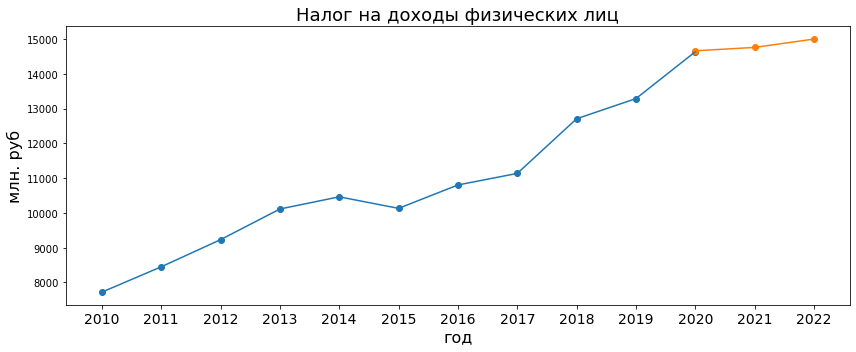

In [13]:
width = 0.4  # the width of the bars
xt = np.arange(len(X.index))

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(xt, y[TARGETS[0]])
ax.scatter(xt, y[TARGETS[0]])
ax.plot(xt[-YEARS_PREDICT:], df[0])
ax.scatter(xt[-YEARS_PREDICT:], df[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('млн. руб', fontsize=FONTSIZE+2)
ax.set_xlabel('год', fontsize=FONTSIZE+2)

ax.set_title(TARGETS[0], fontsize=FONTSIZE+4)
ax.set_xticks(xt)
ax.set_xticklabels([str(y) for y in X.index], fontsize=FONTSIZE)
fig.tight_layout()

plt.show()

#### Предсказание доходов от налогов на прибыль организаций

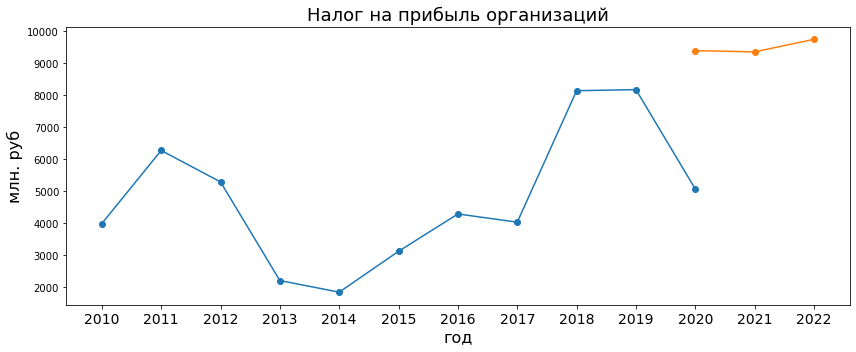

In [14]:
width = 0.4  # the width of the bars
xt = np.arange(len(X.index))

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(xt, y[TARGETS[1]])
ax.scatter(xt, y[TARGETS[1]])
ax.plot(xt[-YEARS_PREDICT:], df[1])
ax.scatter(xt[-YEARS_PREDICT:], df[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('млн. руб', fontsize=FONTSIZE+2)
ax.set_xlabel('год', fontsize=FONTSIZE+2)

ax.set_title(TARGETS[1], fontsize=FONTSIZE+4)
ax.set_xticks(xt)
ax.set_xticklabels([str(y) for y in X.index], fontsize=FONTSIZE)
fig.tight_layout()

plt.show()

На качестве прогноза сказывается недостаток данных целевого признака и невозможность предсказать экстраординарные события.. Падение доходов от налога на прибыль организаций в 2020 году вызванное (скорее всего) пандемией не получается спрогнозировать.